In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from mlxtend.classifier import StackingClassifier
import warnings; warnings.filterwarnings(action='ignore')

In [10]:
#HOPX-2 image features
def expression_type(s):
    it = {b'normal/over':0, b'low':1}
    return it[s]

pathtrain = "/path to train dataset/"
pathtest = "/path to test dataset/"
datatrain = np.loadtxt(pathtrain, dtype=float, delimiter='\t', converters={2:expression_type})
datatest = np.loadtxt(pathtest, dtype=float, delimiter='\t', converters={2:expression_type})

train_data_nosmo, train_label_nosmo=np.split(datatrain,indices_or_sections=(2,),axis=1) #x为数据，y为标签,axis是分割的方向，1表示横向，0表示纵向，默认为0
test_data, test_label=np.split(datatest,indices_or_sections=(2,),axis=1) #x为数据，y为标签,axis是分割的方向，1表示横向，0表示纵向，默认为0
#train_data:训练样本，test_data：测试样本，train_label：训练样本标签，test_label：测试样本标签

smo = SMOTE(random_state=1,k_neighbors=5)
#smo = BorderlineSMOTE(kind='borderline-1',random_state=38, k_neighbors=3)
train_data, train_label = smo.fit_resample(train_data_nosmo, train_label_nosmo)

#svmsmo = SVMSMOTE(random_state=4, k_neighbors=5)
#train_data, train_label = svmsmo.fit_resample(train_data_nosmo, train_label_nosmo)

#ada = ADASYN(random_state=8,n_neighbors=3)
#train_data, train_label = ada.fit_resample(train_data_nosmo, train_label_nosmo)

5-fold cross validation:

0.6666666666666666
[[12  5]
 [ 3  4]]
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75        17
         1.0       0.44      0.57      0.50         7

    accuracy                           0.67        24
   macro avg       0.62      0.64      0.62        24
weighted avg       0.70      0.67      0.68        24

----------------------------------------------------------------
Accuracy: 0.75 (+/- 0.13) [RF]
Accuracy: 0.65 (+/- 0.09) [GBDT]
Accuracy: 0.66 (+/- 0.09) [StackingModel]
Confusion Matrix : 
 [[12  5]
 [ 3  4]]
Accuracy :  0.6666666666666666
Specificity :  0.7058823529411765
Sensitivity :  0.5714285714285714
-----------------------------------------------------------------------
Accuracy= 0.6666666666666666
testAUC= 0.7647058823529411
[1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

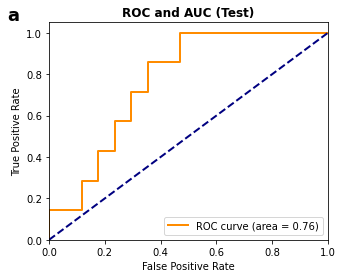

AUC= 0.7647058823529411


In [13]:
#========================================================
#  实现Stacking集成
#========================================================
basemodel1 = svm.SVC(C=6000,kernel='rbf',gamma=0.6,decision_function_shape='ovo',probability=True) 
basemodel2 = RandomForestClassifier(random_state=1044,max_depth=5,max_features=0.9,min_samples_split=3, n_estimators=102)
basemodel3 = GradientBoostingClassifier(random_state=723,learning_rate=0.8,max_depth=7, max_features=0.17,min_samples_split=6,n_estimators=27,subsample=0.5)


meta = LogisticRegression(random_state=100) #meta_classifier  tol=0.0001,C=0.5,random_state=24,max_iter=10

sclf = StackingClassifier(classifiers=[basemodel1, 
                                       #basemodel2,
                                       basemodel3
                                      ], 
                          use_probas=True, #类别概率值作为meta-classfier的输入
                          average_probas=True,  #是否对每一个类别产生的概率值做平均
                          meta_classifier=meta)

sclf.fit(train_data, train_label)

print('5-fold cross validation:\n')

#模型测试
predict_results = sclf.predict(test_data)
predict_results_train = sclf.predict(train_data)

print(accuracy_score(predict_results, test_label))
conf_mat = confusion_matrix(test_label, predict_results)
print(conf_mat)
print(classification_report(test_label, predict_results))
print("----------------------------------------------------------------")


#5折交叉验证
for clf, label in zip([basemodel1,basemodel3,sclf], ['RF','GBDT','StackingModel']):
    scores = model_selection.cross_val_score(clf, train_data, train_label, cv=5, scoring='accuracy')  ##1-recall：sensitivity
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
cm1 = confusion_matrix(test_label,predict_results)
print('Confusion Matrix : \n', cm1)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)
    
prob_predict_y_validation = sclf.predict_proba(test_data)#给出带有概率值的结果，每个点所有label的概率和为1
accuracy = sclf.score(test_data,test_label)
predictions_validation = prob_predict_y_validation[:, 1]
fpr, tpr, _ = roc_curve(test_label, predictions_validation)###计算真正率和假正率
roc_auc = auc(fpr, tpr)##计算auc的值
print("-----------------------------------------------------------------------")
print("Accuracy=",accuracy)
print("testAUC=",auc(fpr, tpr))
print(sclf.predict(test_data))

plt.figure()
lw = 2
plt.figure(figsize=(5,4))
out=plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
out=plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
out=plt.xlim([0.0, 1.0])
out=plt.ylim([0.0, 1.05])
out=plt.xlabel('False Positive Rate',fontsize=10)
out=plt.ylabel('True Positive Rate',fontsize=10)
out=plt.title('ROC and AUC (Test)',fontweight='bold',fontsize=12)
plt.text(-0.15,1.06,"a",fontweight='bold',fontsize=18)
out=plt.legend(loc="lower right")
plt.show()
output = out.get_figure()
#output.savefig('/Users/armandayuu/Desktop/AUCtest111.png',dpi=300,bbox_inches='tight')
print("AUC=",auc(fpr, tpr))